In [51]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('./dataset/data.csv')
dataset.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [52]:
dataset = dataset.drop('shot_id', axis=1)

In [53]:
pd.Series(dataset.dtypes)

action_type            object
combined_shot_type     object
game_event_id           int64
game_id                 int64
lat                   float64
loc_x                   int64
loc_y                   int64
lon                   float64
minutes_remaining       int64
period                  int64
playoffs                int64
season                 object
seconds_remaining       int64
shot_distance           int64
shot_made_flag        float64
shot_type              object
shot_zone_area         object
shot_zone_basic        object
shot_zone_range        object
team_id                 int64
team_name              object
game_date              object
matchup                object
opponent               object
dtype: object

In [54]:
X_train = dataset[dataset['shot_made_flag'].notnull()]
y_train = X_train['shot_made_flag']
X_train = X_train.drop(columns='shot_made_flag', axis=1 )
X_train.shape

(25697, 23)

In [55]:
X_test = dataset[dataset['shot_made_flag'].isnull()].drop( 'shot_made_flag',axis=1)
X_test.shape

(5000, 23)

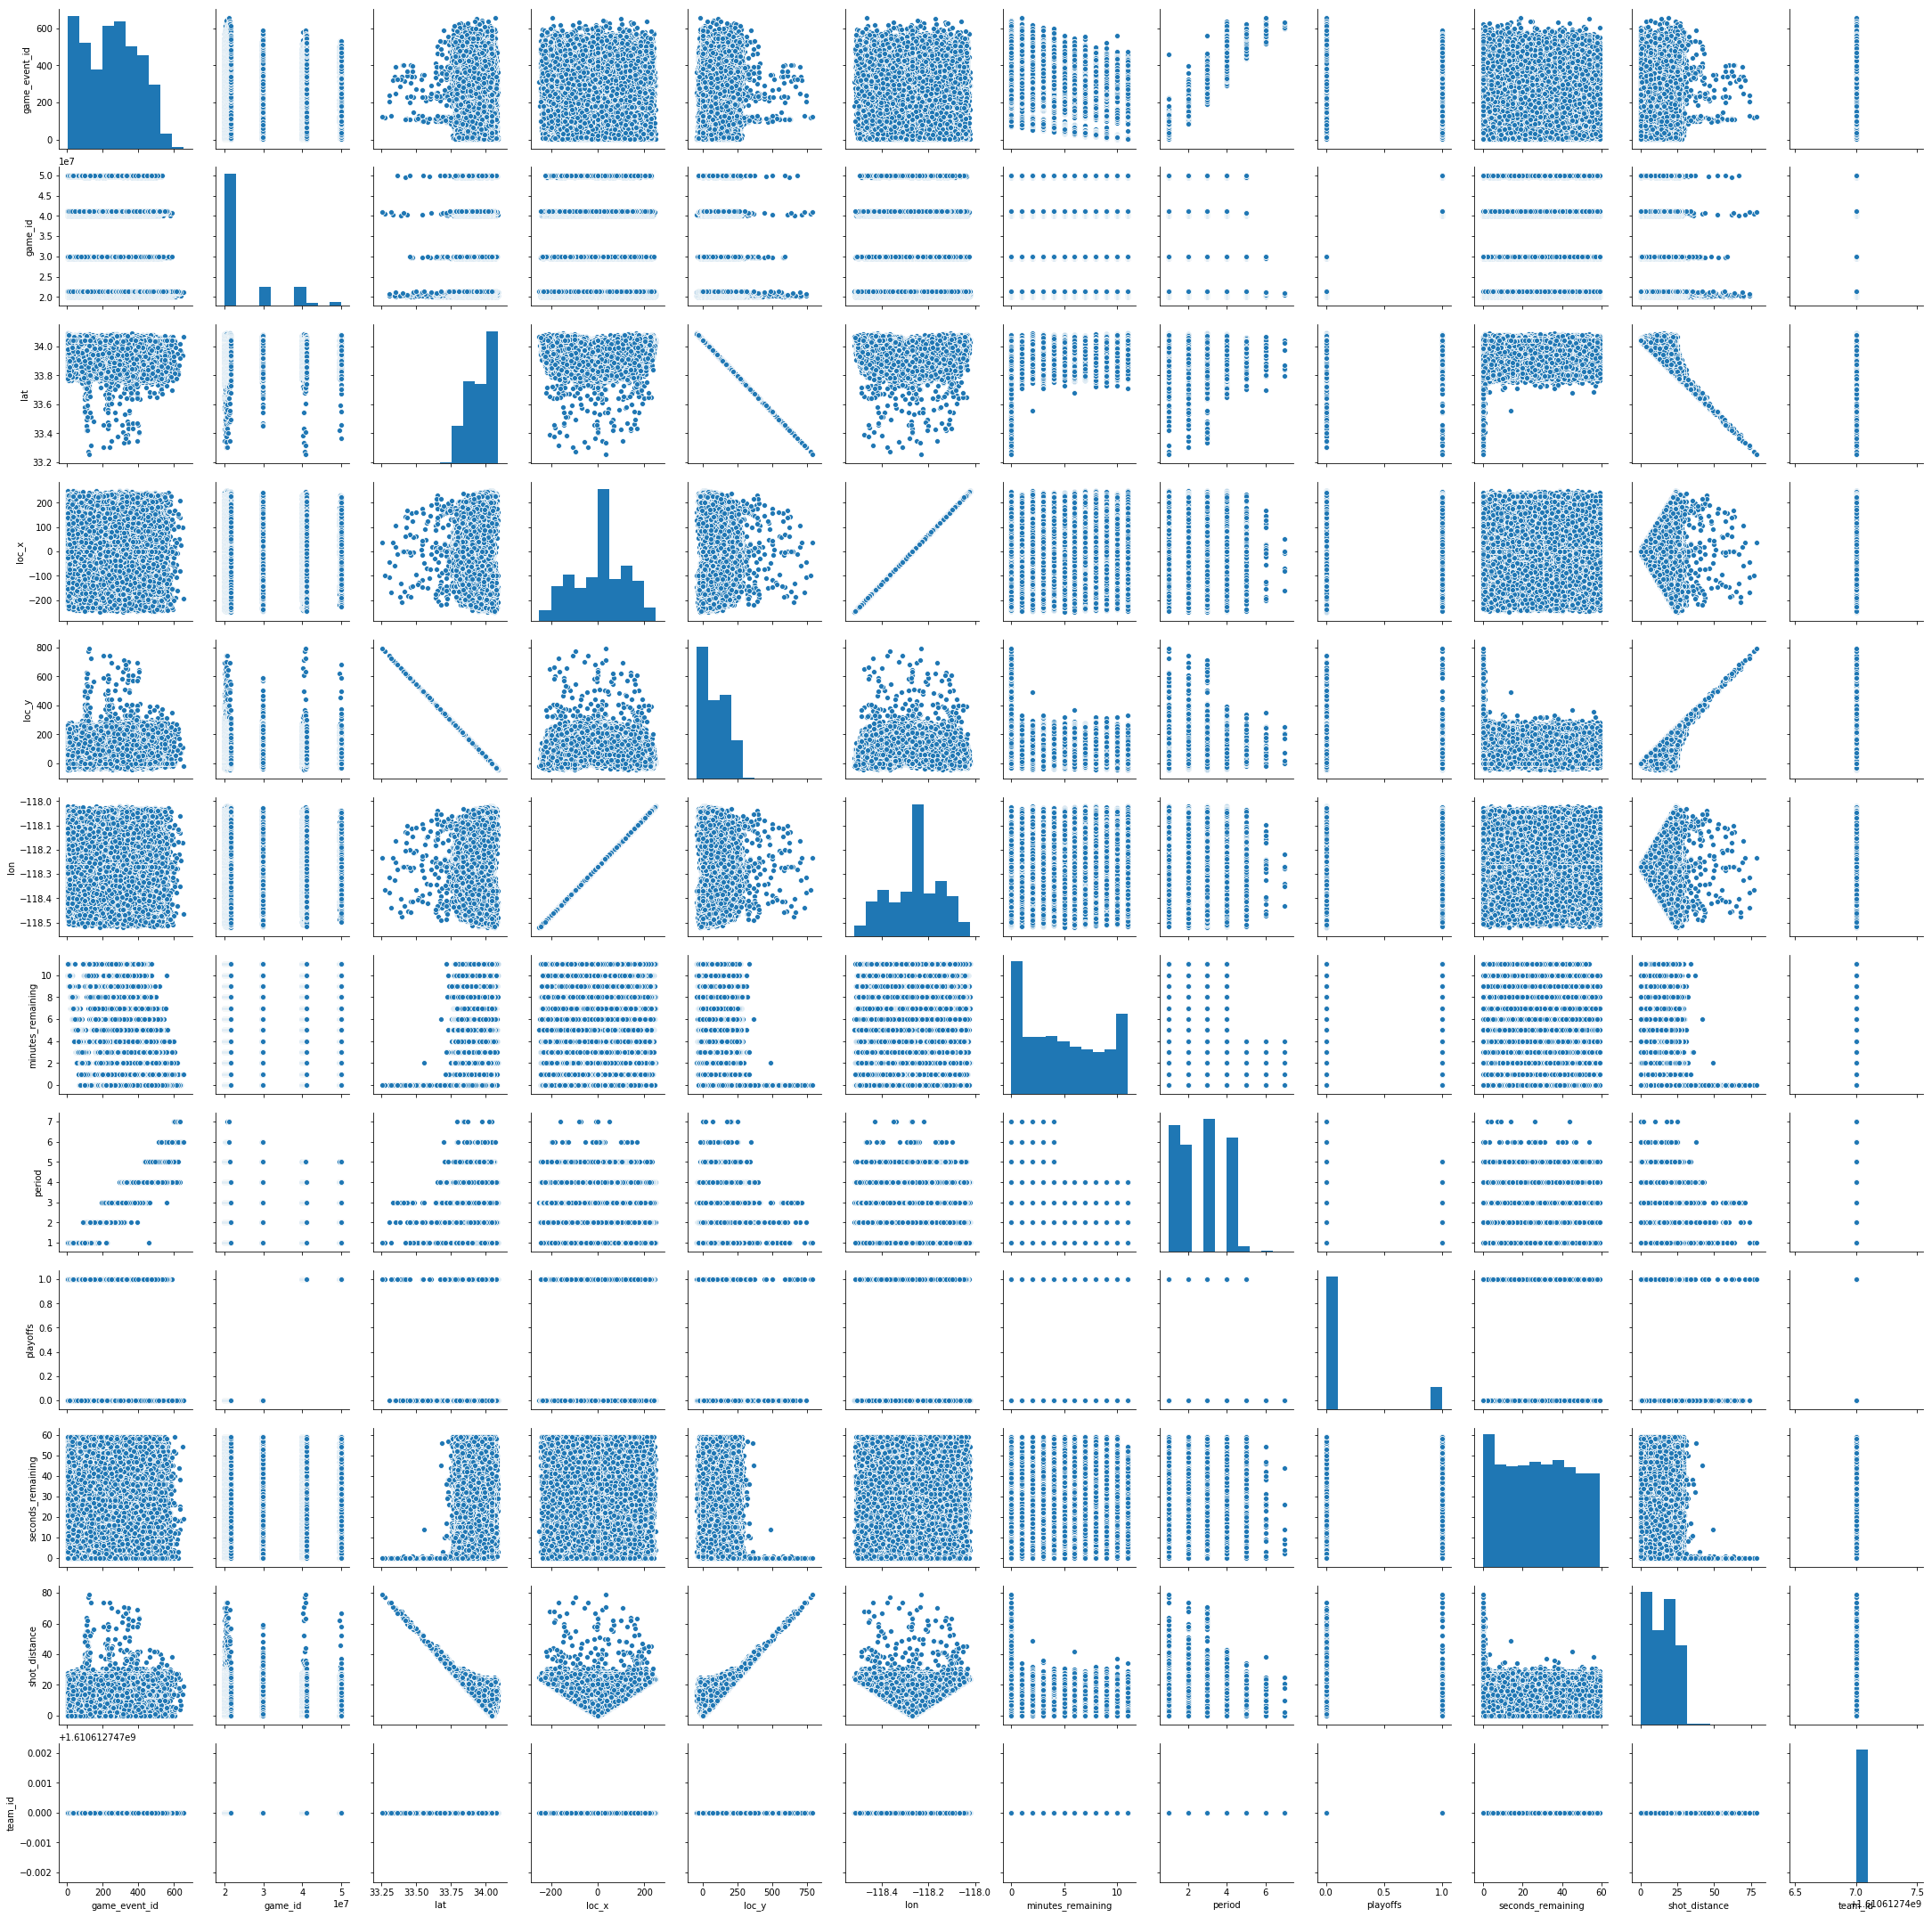

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(X_train)
plt.show()

<BarContainer object of 10 artists>

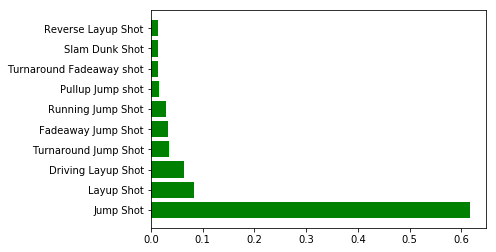

In [73]:
#action_typeの割合を調べる

#カラム抽出
ind = X_train['action_type'].value_counts(normalize=True)[:10].index
#値抽出
val = X_train['action_type'].value_counts(normalize=True)[:10].values

fig, ax = plt.subplots()

ax.barh(ind, val , align='center',color='green', ecolor='black')

<BarContainer object of 6 artists>

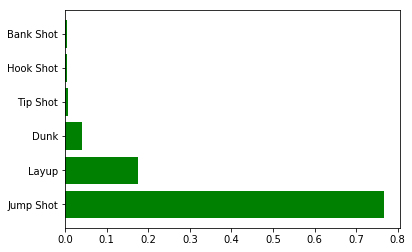

In [38]:
ind = X_train['combined_shot_type'].value_counts(normalize=True).index
val = X_train['combined_shot_type'].value_counts(normalize=True).values

fig, ax = plt.subplots()

ax.barh(ind, val , align='center',color='green', ecolor='black')

In [ ]:
#試合ごとに平均してjump shotが多いか調べる
#横軸：試合id　縦軸：shot_type

index = X_train['game_event_id']
val = X_train['combined_shot_type'].value_counts()

<BarContainer object of 6 artists>

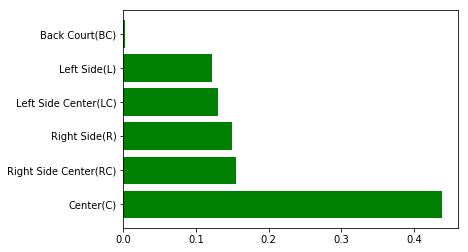

In [62]:
#ボールを投げる場所
ind = X_train['shot_zone_area'].value_counts(normalize=True).index
val = X_train['shot_zone_area'].value_counts(normalize=True).values

fig, ax = plt.subplots()

ax.barh(ind, val , align='center',color='green', ecolor='black')

<BarContainer object of 2 artists>

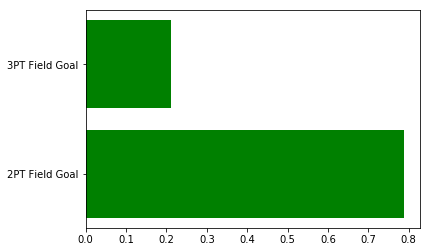

In [44]:
#2pt/3ptシュートの割合
ind = X_train['shot_type'].value_counts(normalize=True).index
val = X_train['shot_type'].value_counts(normalize=True).values

fig, ax = plt.subplots()

ax.barh(ind, val , align='center',color='green', ecolor='black')